# Notebook 03 : Analyse de Clustering
## 4 Algorithmes de Clustering Non-Supervisé avec MLflow Tracking

---

### Algorithmes implémentés :

| # | Algorithme | Type | Caractéristiques |
|---|------------|------|-------------------|
| 1 | **K-Means** | Partitionnement | Nombre de clusters fixe, centröides |
| 2 | **DBSCAN** | Densité | Détecte outliers, clusters de forme arbitraire |
| 3 | **Agglomératif** | Hiérarchique | Dendrogramme, fusion ascendante |
| 4 | **Spectral** | Graphe | Basé sur similarité, clusters non-convexes |

### Métriques d'évaluation :
- **Silhouette Score** : [-1, 1] - Plus élevé = meilleur
- **Davies-Bouldin Index** : [0, +∞] - Plus bas = meilleur
- **Calinski-Harabasz Score** : [0, +∞] - Plus élevé = meilleur



## 1. Configuration et Imports

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Sklearn - Prétraitement
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Sklearn - Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering

# Sklearn - Métriques
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    davies_bouldin_score, calinski_harabasz_score
)

# Dendrogramme
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# MLflow
import mlflow
import mlflow.sklearn

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Couleurs pour les clusters
CLUSTER_COLORS = ['#E74C3C', '#3498DB', '#2ECC71', '#9B59B6', '#F39C12', 
                  '#1ABC9C', '#E91E63', '#00BCD4', '#FF5722', '#607D8B']

print(f"Configuration terminée - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Configuration terminée - 2026-02-13 17:55:12


## 2. Configuration MLflow

In [2]:
# ============================================================================
# CONFIGURATION MLFLOW
# ============================================================================

mlflow.set_tracking_uri("file:./mlruns")
EXPERIMENT_NAME = "Heart_Disease_Clustering"

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(
        EXPERIMENT_NAME,
        tags={"project": "Heart Disease", "phase": "Clustering"}
    )
else:
    experiment_id = experiment.experiment_id

mlflow.set_experiment(EXPERIMENT_NAME)
print(f"MLflow Experiment: {EXPERIMENT_NAME} (ID: {experiment_id})")
print("Pour visualiser: mlflow ui --port 5000")

MLflow Experiment: Heart_Disease_Clustering (ID: 189608228128741953)
Pour visualiser: mlflow ui --port 5000


## 3. Chargement et Préparation des Données

In [3]:
# ============================================================================
# CHARGEMENT DES DONNÉES
# ============================================================================

df = pd.read_csv('heart.csv')
print(f"Dataset chargé: {df.shape[0]} patients x {df.shape[1]} variables")

# Sauvegarder la variable cible pour analyse post-clustering
y_true = df['target'].copy()

# Exclure la variable cible pour le clustering (non-supervisé)
X = df.drop('target', axis=1)
feature_names = X.columns.tolist()

print(f"\nFeatures pour clustering: {len(feature_names)}")
print(f"Variables: {feature_names}")

Dataset chargé: 1025 patients x 14 variables

Features pour clustering: 13
Variables: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [4]:
# ============================================================================
# STANDARDISATION DES DONNÉES
# ============================================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Données standardisées avec StandardScaler")
print(f"Moyenne: {X_scaled.mean(axis=0).round(4)[:3]}... (proche de 0)")
print(f"Écart-type: {X_scaled.std(axis=0).round(4)[:3]}... (proche de 1)")

Données standardisées avec StandardScaler
Moyenne: [-0.  0.  0.]... (proche de 0)
Écart-type: [1. 1. 1.]... (proche de 1)


In [5]:
# ============================================================================
# RÉDUCTION PCA POUR VISUALISATION 2D
# ============================================================================

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"\nPCA pour visualisation 2D:")
print(f"  - Variance expliquée PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  - Variance expliquée PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  - Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")


PCA pour visualisation 2D:
  - Variance expliquée PC1: 21.37%
  - Variance expliquée PC2: 11.97%
  - Total: 33.34%


## 4. Fonctions Utilitaires

In [6]:
# ============================================================================
# FONCTIONS D'ÉVALUATION ET VISUALISATION
# ============================================================================

def calculate_clustering_metrics(X, labels):
    """
    Calcule toutes les métriques de clustering.
    Retourne None pour les métriques si clustering invalide.
    """
    # Vérifier qu'on a au moins 2 clusters
    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)  # Exclure le bruit pour le comptage
    n_clusters = len(unique_labels)
    
    # Si moins de 2 clusters ou tous les points sont du bruit
    if n_clusters < 2:
        return {
            'silhouette': None,
            'davies_bouldin': None,
            'calinski_harabasz': None,
            'n_clusters': n_clusters
        }
    
    # Pour DBSCAN, exclure les points de bruit pour les métriques
    mask = labels != -1
    if mask.sum() < 2:
        return {
            'silhouette': None,
            'davies_bouldin': None,
            'calinski_harabasz': None,
            'n_clusters': n_clusters
        }
    
    X_valid = X[mask]
    labels_valid = labels[mask]
    
    # Vérifier encore une fois le nombre de clusters
    if len(set(labels_valid)) < 2:
        return {
            'silhouette': None,
            'davies_bouldin': None,
            'calinski_harabasz': None,
            'n_clusters': n_clusters
        }
    
    return {
        'silhouette': silhouette_score(X_valid, labels_valid),
        'davies_bouldin': davies_bouldin_score(X_valid, labels_valid),
        'calinski_harabasz': calinski_harabasz_score(X_valid, labels_valid),
        'n_clusters': n_clusters
    }


def plot_clusters_2d(X_2d, labels, title, ax=None, show_noise=True):
    """
    Visualise les clusters en 2D.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    unique_labels = sorted(set(labels))
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        if label == -1:
            # Points de bruit (DBSCAN)
            if show_noise:
                ax.scatter(X_2d[mask, 0], X_2d[mask, 1], c='gray', 
                          marker='x', s=30, alpha=0.5, label='Bruit')
        else:
            color = CLUSTER_COLORS[label % len(CLUSTER_COLORS)]
            ax.scatter(X_2d[mask, 0], X_2d[mask, 1], c=color,
                      s=50, alpha=0.7, edgecolor='black', linewidth=0.5,
                      label=f'Cluster {label}')
    
    ax.set_xlabel('PC1', fontsize=11)
    ax.set_ylabel('PC2', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    
    return ax


def plot_silhouette(X, labels, title, ax=None):
    """
    Crée un silhouette plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Exclure le bruit
    mask = labels != -1
    if mask.sum() < 2 or len(set(labels[mask])) < 2:
        ax.text(0.5, 0.5, 'Silhouette Plot non disponible\n(moins de 2 clusters)',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        return ax
    
    X_valid = X[mask]
    labels_valid = labels[mask]
    
    silhouette_vals = silhouette_samples(X_valid, labels_valid)
    silhouette_avg = silhouette_vals.mean()
    
    y_lower = 10
    unique_labels = sorted(set(labels_valid))
    
    for i, label in enumerate(unique_labels):
        cluster_silhouette_vals = silhouette_vals[labels_valid == label]
        cluster_silhouette_vals.sort()
        
        cluster_size = len(cluster_silhouette_vals)
        y_upper = y_lower + cluster_size
        
        color = CLUSTER_COLORS[label % len(CLUSTER_COLORS)]
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(label), fontsize=10)
        y_lower = y_upper + 10
    
    ax.axvline(x=silhouette_avg, color='red', linestyle='--', 
               label=f'Moyenne: {silhouette_avg:.3f}')
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Cluster')
    ax.set_title(title, fontweight='bold')
    ax.legend(loc='best')
    
    return ax

print("Fonctions utilitaires définies.")

Fonctions utilitaires définies.


In [7]:
# Stockage des résultats
all_results = []
best_models = {}

---

## 5. Algorithme 1 : K-Means

**Principe :** Partitionne les données en K clusters en minimisant l'inertie (variance intra-cluster).

In [8]:
# ============================================================================
# K-MEANS CLUSTERING
# ============================================================================

print("="*70)
print("ALGORITHME 1 : K-MEANS CLUSTERING")
print("="*70)

# Plage de k à tester
k_range = range(2, 11)

# Stockage pour l'analyse
kmeans_inertias = []
kmeans_silhouettes = []
kmeans_results = []

print("\nTest de différentes valeurs de k...")

for k in k_range:
    with mlflow.start_run(run_name=f"KMeans_k{k}"):
        start_time = time.time()
        
        # Entraînement
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, 
                        max_iter=300, random_state=RANDOM_STATE)
        labels = kmeans.fit_predict(X_scaled)
        
        exec_time = time.time() - start_time
        
        # Métriques
        metrics = calculate_clustering_metrics(X_scaled, labels)
        inertia = kmeans.inertia_
        
        kmeans_inertias.append(inertia)
        kmeans_silhouettes.append(metrics['silhouette'])
        
        # Log MLflow
        mlflow.log_param("algorithm", "KMeans")
        mlflow.log_param("k", k)
        mlflow.log_param("init", "k-means++")
        mlflow.log_param("n_init", 10)
        
        mlflow.log_metric("inertia", inertia)
        mlflow.log_metric("silhouette_score", metrics['silhouette'] or 0)
        mlflow.log_metric("davies_bouldin", metrics['davies_bouldin'] or 0)
        mlflow.log_metric("calinski_harabasz", metrics['calinski_harabasz'] or 0)
        mlflow.log_metric("execution_time", exec_time)
        
        mlflow.sklearn.log_model(kmeans, f"kmeans_k{k}")
        
        # Stocker résultats
        result = {
            'algorithm': 'K-Means',
            'params': f'k={k}',
            'n_clusters': k,
            'silhouette': metrics['silhouette'],
            'davies_bouldin': metrics['davies_bouldin'],
            'calinski_harabasz': metrics['calinski_harabasz'],
            'inertia': inertia,
            'n_noise': 0,
            'time': exec_time,
            'labels': labels,
            'model': kmeans
        }
        kmeans_results.append(result)
        
        print(f"  k={k}: Silhouette={metrics['silhouette']:.4f}, Inertia={inertia:.2f}")

# Trouver le meilleur k (selon Silhouette)
best_k_idx = np.argmax(kmeans_silhouettes)
best_kmeans = kmeans_results[best_k_idx]
best_models['K-Means'] = best_kmeans
all_results.append(best_kmeans)

print(f"\n\u2705 Meilleur K-Means: k={best_kmeans['n_clusters']} (Silhouette={best_kmeans['silhouette']:.4f})")

ALGORITHME 1 : K-MEANS CLUSTERING

Test de différentes valeurs de k...


2026/02/13 17:55:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  k=2: Silhouette=0.1701, Inertia=11245.05


2026/02/13 17:55:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  k=3: Silhouette=0.1247, Inertia=10414.10


2026/02/13 17:55:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  k=4: Silhouette=0.1324, Inertia=9689.66


2026/02/13 17:55:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  k=5: Silhouette=0.1277, Inertia=9222.36


2026/02/13 17:55:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  k=6: Silhouette=0.1294, Inertia=8894.66


2026/02/13 17:56:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  k=7: Silhouette=0.1235, Inertia=8524.58


2026/02/13 17:56:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  k=8: Silhouette=0.1122, Inertia=8295.21


2026/02/13 17:56:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  k=9: Silhouette=0.1127, Inertia=8096.98


2026/02/13 17:56:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  k=10: Silhouette=0.1172, Inertia=7836.89

✅ Meilleur K-Means: k=2 (Silhouette=0.1701)


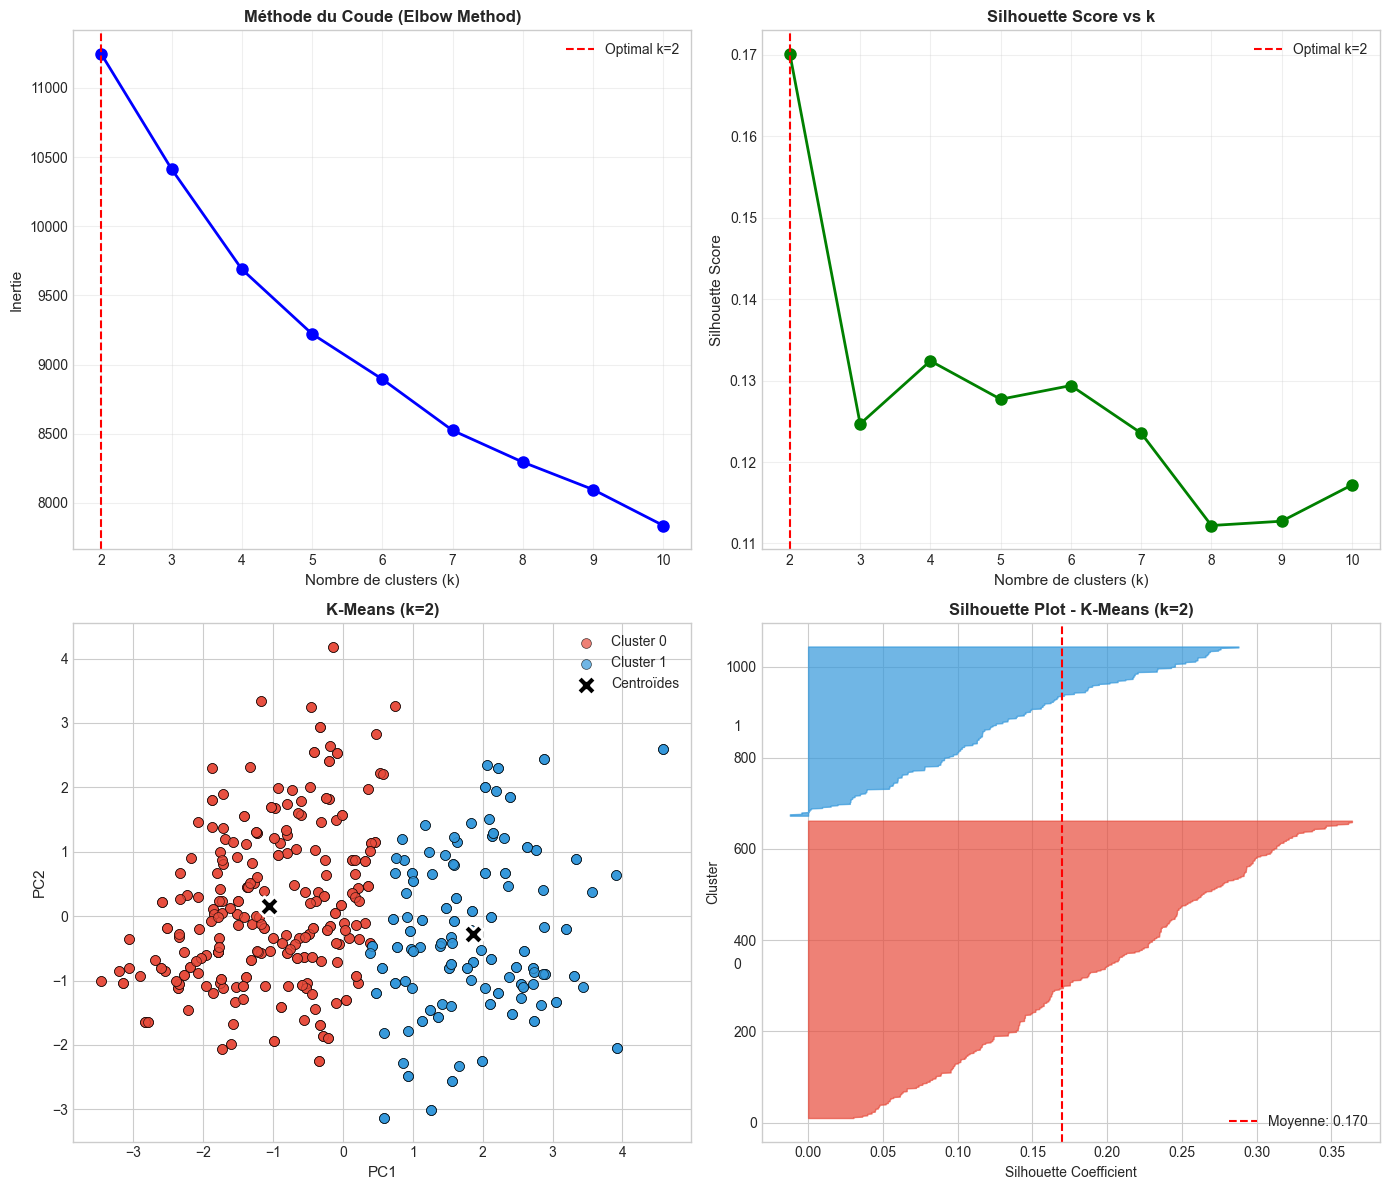

Figure sauvegardée: kmeans_analysis.png


In [9]:
# ============================================================================
# VISUALISATION K-MEANS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Elbow Method
ax1 = axes[0, 0]
ax1.plot(list(k_range), kmeans_inertias, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=best_kmeans['n_clusters'], color='red', linestyle='--', 
            label=f'Optimal k={best_kmeans["n_clusters"]}')
ax1.set_xlabel('Nombre de clusters (k)', fontsize=11)
ax1.set_ylabel('Inertie', fontsize=11)
ax1.set_title('Méthode du Coude (Elbow Method)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Silhouette Score vs k
ax2 = axes[0, 1]
ax2.plot(list(k_range), kmeans_silhouettes, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=best_kmeans['n_clusters'], color='red', linestyle='--',
            label=f'Optimal k={best_kmeans["n_clusters"]}')
ax2.set_xlabel('Nombre de clusters (k)', fontsize=11)
ax2.set_ylabel('Silhouette Score', fontsize=11)
ax2.set_title('Silhouette Score vs k', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Clusters 2D (meilleur k)
ax3 = axes[1, 0]
plot_clusters_2d(X_pca, best_kmeans['labels'], 
                 f'K-Means (k={best_kmeans["n_clusters"]})', ax=ax3)
# Ajouter les centroïdes
centroids_pca = pca.transform(best_kmeans['model'].cluster_centers_)
ax3.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='black', 
            marker='X', s=200, edgecolor='white', linewidth=2, label='Centroïdes')
ax3.legend()

# 4. Silhouette Plot
ax4 = axes[1, 1]
plot_silhouette(X_scaled, best_kmeans['labels'], 
                f'Silhouette Plot - K-Means (k={best_kmeans["n_clusters"]})', ax=ax4)

plt.tight_layout()
plt.savefig('images/kmeans_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée: kmeans_analysis.png")

---

## 6. Algorithme 2 : DBSCAN

**Principe :** Détecte les clusters basés sur la densité et identifie automatiquement les outliers.

In [11]:
# ============================================================================
# DBSCAN CLUSTERING
# ============================================================================

print("\n" + "="*70)
print("ALGORITHME 2 : DBSCAN")
print("="*70)

# Paramètres à tester
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
min_samples_values = [3, 5, 7, 10]

dbscan_results = []
best_dbscan_score = -1
best_dbscan = None

print("\nTest de différentes combinaisons eps/min_samples...")

for eps in eps_values:
    for min_samples in min_samples_values:
        with mlflow.start_run(run_name=f"DBSCAN_eps{eps}_min{min_samples}"):
            start_time = time.time()
            
            # Entraînement
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
            labels = dbscan.fit_predict(X_scaled)
            
            exec_time = time.time() - start_time
            
            # Comptage
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = (labels == -1).sum()
            
            # Métriques
            metrics = calculate_clustering_metrics(X_scaled, labels)
            
            # Log MLflow
            mlflow.log_param("algorithm", "DBSCAN")
            mlflow.log_param("eps", eps)
            mlflow.log_param("min_samples", min_samples)
            
            mlflow.log_metric("n_clusters", n_clusters)
            mlflow.log_metric("n_noise", n_noise)
            mlflow.log_metric("noise_ratio", n_noise / len(labels))
            mlflow.log_metric("silhouette_score", metrics['silhouette'] or 0)
            mlflow.log_metric("davies_bouldin", metrics['davies_bouldin'] or 0)
            mlflow.log_metric("calinski_harabasz", metrics['calinski_harabasz'] or 0)
            mlflow.log_metric("execution_time", exec_time)
            
            # Stocker résultats
            result = {
                'algorithm': 'DBSCAN',
                'params': f'eps={eps}, min_samples={min_samples}',
                'n_clusters': n_clusters,
                'silhouette': metrics['silhouette'],
                'davies_bouldin': metrics['davies_bouldin'],
                'calinski_harabasz': metrics['calinski_harabasz'],
                'n_noise': n_noise,
                'time': exec_time,
                'labels': labels,
                'model': dbscan,
                'eps': eps,
                'min_samples': min_samples
            }
            dbscan_results.append(result)
            
            # Meilleur modèle (clusters >= 2 et meilleur silhouette)
            if n_clusters >= 2 and metrics['silhouette'] is not None:
                if metrics['silhouette'] > best_dbscan_score:
                    best_dbscan_score = metrics['silhouette']
                    best_dbscan = result
            
            if n_clusters >= 2:
                sil_str = f"{metrics['silhouette']:.4f}" if metrics['silhouette'] is not None else 'N/A'
                print(f"  eps={eps}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} bruit, Sil={sil_str}")

if best_dbscan:
    best_models['DBSCAN'] = best_dbscan
    all_results.append(best_dbscan)
    print(f"\n✅ Meilleur DBSCAN: {best_dbscan['params']} (Silhouette={best_dbscan['silhouette']:.4f})")
else:
    print("\n⚠️ Aucune configuration DBSCAN valide trouvée")


ALGORITHME 2 : DBSCAN

Test de différentes combinaisons eps/min_samples...
  eps=0.3, min_samples=3: 301 clusters, 0 bruit, Sil=0.9996
  eps=0.3, min_samples=5: 2 clusters, 1011 bruit, Sil=0.9897
  eps=0.5, min_samples=3: 300 clusters, 0 bruit, Sil=0.9985
  eps=0.5, min_samples=5: 3 clusters, 1005 bruit, Sil=0.9675
  eps=0.7, min_samples=3: 300 clusters, 0 bruit, Sil=0.9985
  eps=0.7, min_samples=5: 3 clusters, 1005 bruit, Sil=0.9675
  eps=1.0, min_samples=3: 293 clusters, 0 bruit, Sil=0.9793
  eps=1.0, min_samples=5: 8 clusters, 964 bruit, Sil=0.8181
  eps=1.0, min_samples=7: 3 clusters, 994 bruit, Sil=0.8757
  eps=1.5, min_samples=3: 253 clusters, 0 bruit, Sil=0.8547
  eps=1.5, min_samples=5: 19 clusters, 793 bruit, Sil=0.5164
  eps=1.5, min_samples=7: 16 clusters, 811 bruit, Sil=0.5096
  eps=1.5, min_samples=10: 5 clusters, 908 bruit, Sil=0.4805
  eps=2.0, min_samples=3: 182 clusters, 0 bruit, Sil=0.6402
  eps=2.0, min_samples=5: 28 clusters, 526 bruit, Sil=0.3623
  eps=2.0, min_sa

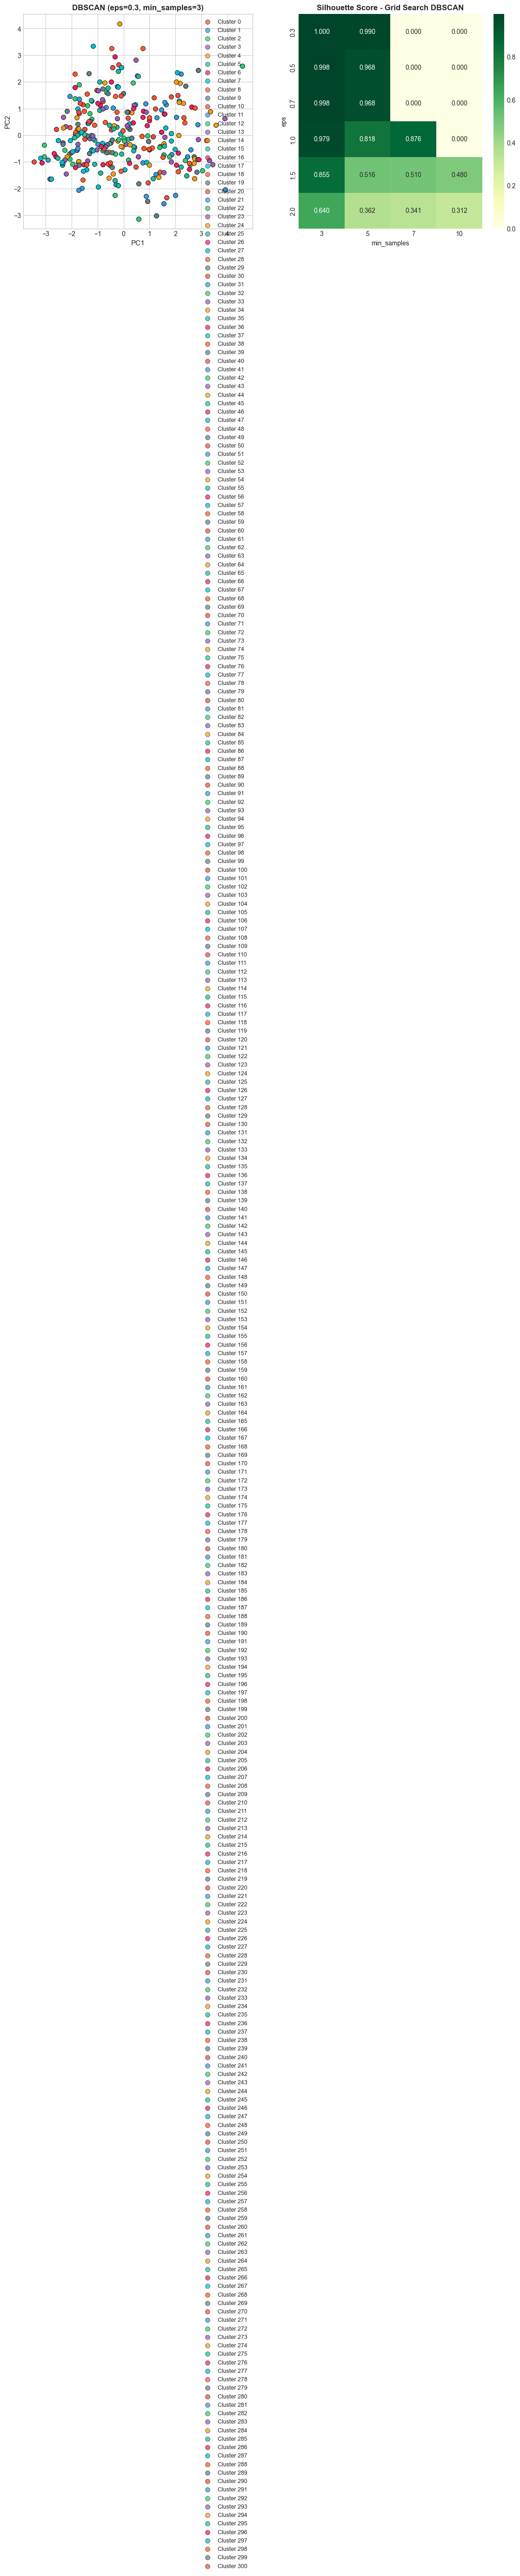


Statistiques DBSCAN:
  - Clusters trouvés: 301
  - Points de bruit: 0 (0.0%)


In [12]:
# ============================================================================
# VISUALISATION DBSCAN
# ============================================================================

if best_dbscan:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Clusters 2D
    ax1 = axes[0]
    plot_clusters_2d(X_pca, best_dbscan['labels'], 
                     f'DBSCAN ({best_dbscan["params"]})', ax=ax1)
    
    # 2. Heatmap des résultats DBSCAN
    ax2 = axes[1]
    # Créer matrice des silhouette scores
    heatmap_data = np.zeros((len(eps_values), len(min_samples_values)))
    for result in dbscan_results:
        i = eps_values.index(result['eps'])
        j = min_samples_values.index(result['min_samples'])
        heatmap_data[i, j] = result['silhouette'] if result['silhouette'] else 0
    
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGn',
                xticklabels=min_samples_values, yticklabels=eps_values, ax=ax2)
    ax2.set_xlabel('min_samples')
    ax2.set_ylabel('eps')
    ax2.set_title('Silhouette Score - Grid Search DBSCAN', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('images/dbscan_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nStatistiques DBSCAN:")
    print(f"  - Clusters trouvés: {best_dbscan['n_clusters']}")
    print(f"  - Points de bruit: {best_dbscan['n_noise']} ({best_dbscan['n_noise']/len(X)*100:.1f}%)")

---

## 7. Algorithme 3 : Clustering Hiérarchique Agglomératif

**Principe :** Construit une hiérarchie de clusters par fusion successive (bottom-up).

In [13]:
# ============================================================================
# CLUSTERING HIÉRARCHIQUE
# ============================================================================

print("\n" + "="*70)
print("ALGORITHME 3 : CLUSTERING HIÉRARCHIQUE AGGLOMÉRATIF")
print("="*70)

# Paramètres à tester
linkage_methods = ['ward', 'complete', 'average']
n_clusters_range = range(2, 11)

hierarchical_results = []
best_hierarchical_score = -1
best_hierarchical = None

print("\nTest de différentes configurations...")

for linkage_method in linkage_methods:
    for n_clusters in n_clusters_range:
        with mlflow.start_run(run_name=f"Hierarchical_{linkage_method}_n{n_clusters}"):
            start_time = time.time()
            
            # Entraînement
            hierarchical = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage=linkage_method
            )
            labels = hierarchical.fit_predict(X_scaled)
            
            exec_time = time.time() - start_time
            
            # Métriques
            metrics = calculate_clustering_metrics(X_scaled, labels)
            
            # Log MLflow
            mlflow.log_param("algorithm", "Hierarchical")
            mlflow.log_param("linkage", linkage_method)
            mlflow.log_param("n_clusters", n_clusters)
            
            mlflow.log_metric("silhouette_score", metrics['silhouette'] or 0)
            mlflow.log_metric("davies_bouldin", metrics['davies_bouldin'] or 0)
            mlflow.log_metric("calinski_harabasz", metrics['calinski_harabasz'] or 0)
            mlflow.log_metric("execution_time", exec_time)
            
            # Stocker résultats
            result = {
                'algorithm': 'Hierarchical',
                'params': f'linkage={linkage_method}, n={n_clusters}',
                'n_clusters': n_clusters,
                'silhouette': metrics['silhouette'],
                'davies_bouldin': metrics['davies_bouldin'],
                'calinski_harabasz': metrics['calinski_harabasz'],
                'n_noise': 0,
                'time': exec_time,
                'labels': labels,
                'model': hierarchical,
                'linkage': linkage_method
            }
            hierarchical_results.append(result)
            
            # Meilleur modèle
            if metrics['silhouette'] and metrics['silhouette'] > best_hierarchical_score:
                best_hierarchical_score = metrics['silhouette']
                best_hierarchical = result

best_models['Hierarchical'] = best_hierarchical
all_results.append(best_hierarchical)

print(f"\n\u2705 Meilleur Hiérarchique: {best_hierarchical['params']} (Silhouette={best_hierarchical['silhouette']:.4f})")


ALGORITHME 3 : CLUSTERING HIÉRARCHIQUE AGGLOMÉRATIF

Test de différentes configurations...

✅ Meilleur Hiérarchique: linkage=complete, n=2 (Silhouette=0.3592)


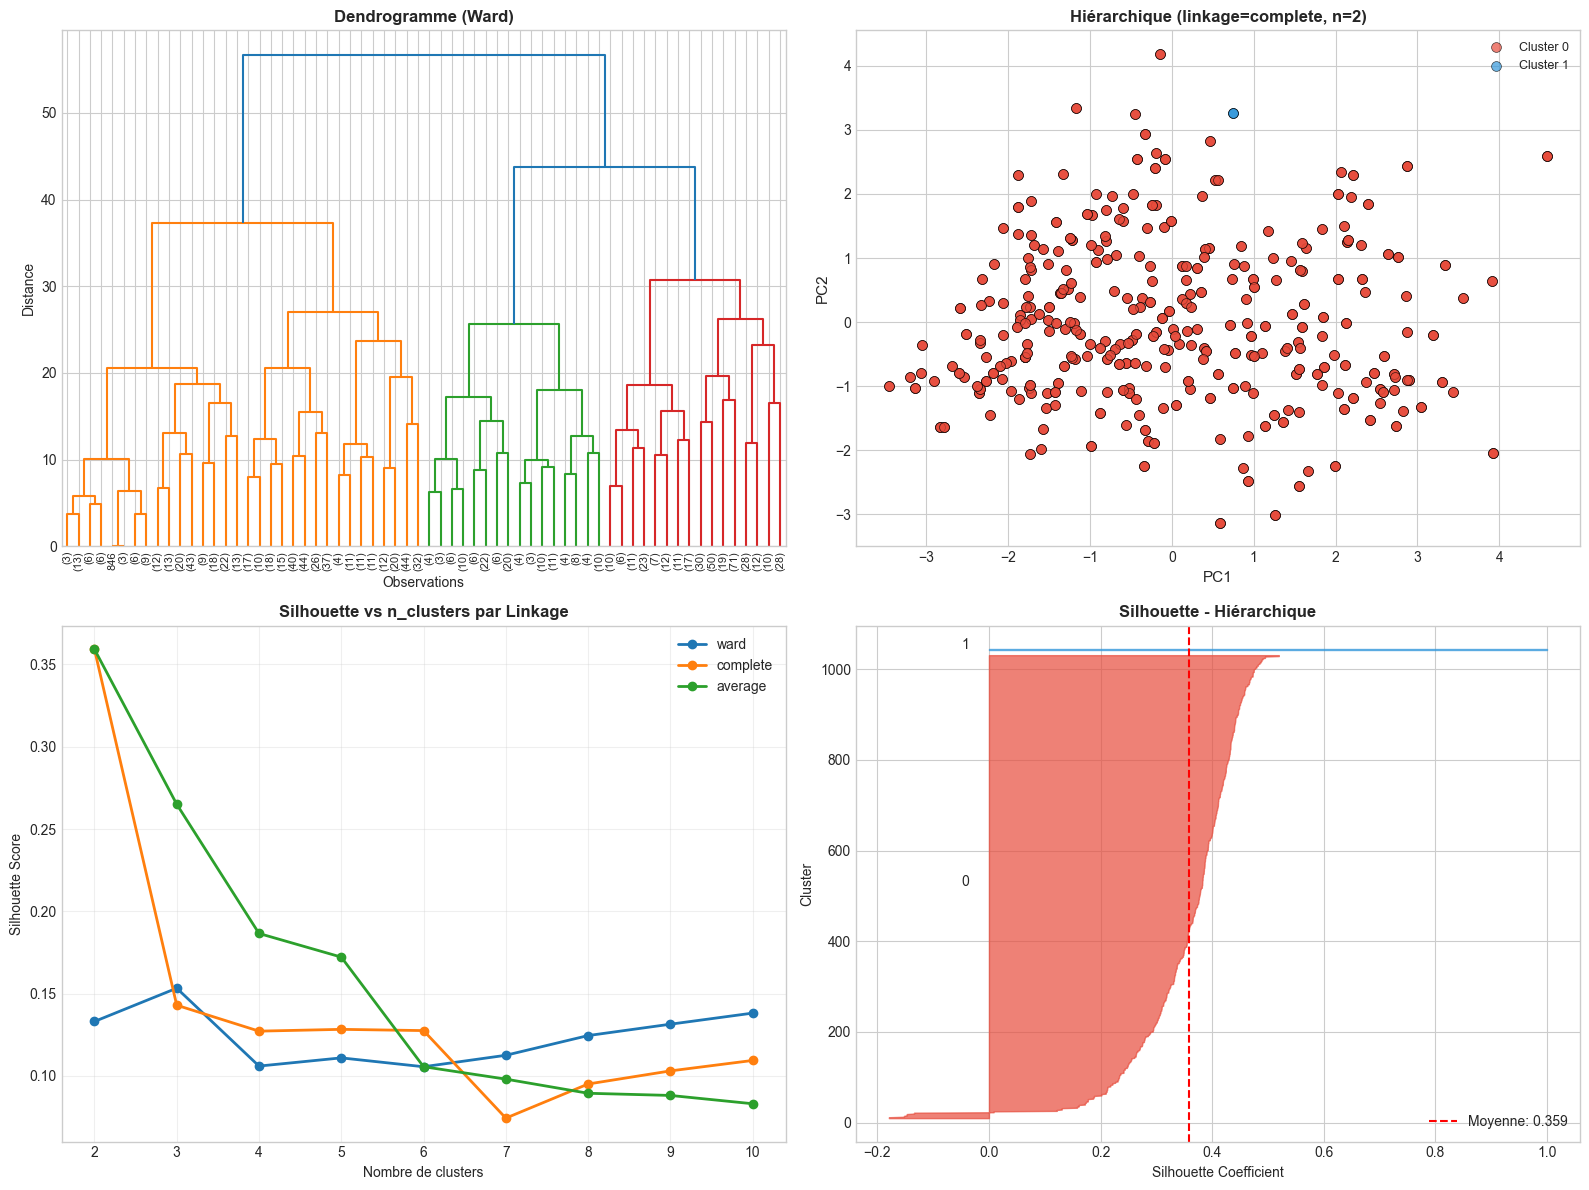

Figure sauvegardée: hierarchical_analysis.png


In [14]:
# ============================================================================
# DENDROGRAMME
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Dendrogramme (Ward)
ax1 = axes[0, 0]
linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix, ax=ax1, truncate_mode='level', p=5,
           leaf_rotation=90, leaf_font_size=8, color_threshold=0.7*max(linkage_matrix[:, 2]))
ax1.set_title('Dendrogramme (Ward)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Observations')
ax1.set_ylabel('Distance')

# 2. Clusters 2D
ax2 = axes[0, 1]
plot_clusters_2d(X_pca, best_hierarchical['labels'],
                 f'Hiérarchique ({best_hierarchical["params"]})', ax=ax2)

# 3. Comparaison des linkages
ax3 = axes[1, 0]
for linkage_method in linkage_methods:
    silhouettes = [r['silhouette'] for r in hierarchical_results 
                   if r['linkage'] == linkage_method]
    ax3.plot(list(n_clusters_range), silhouettes, 'o-', 
             linewidth=2, markersize=6, label=linkage_method)
ax3.set_xlabel('Nombre de clusters')
ax3.set_ylabel('Silhouette Score')
ax3.set_title('Silhouette vs n_clusters par Linkage', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Silhouette Plot
ax4 = axes[1, 1]
plot_silhouette(X_scaled, best_hierarchical['labels'],
                f'Silhouette - Hiérarchique', ax=ax4)

plt.tight_layout()
plt.savefig('images/hierarchical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée: hierarchical_analysis.png")

---

## 8. Algorithme 4 : Spectral Clustering

**Principe :** Utilise les vecteurs propres de la matrice de similarité pour le clustering.

In [15]:
# ============================================================================
# SPECTRAL CLUSTERING
# ============================================================================

print("\n" + "="*70)
print("ALGORITHME 4 : SPECTRAL CLUSTERING")
print("="*70)

# Paramètres à tester
affinity_methods = ['rbf', 'nearest_neighbors']
n_clusters_range = range(2, 11)

spectral_results = []
best_spectral_score = -1
best_spectral = None

print("\nTest de différentes configurations...")

for affinity in affinity_methods:
    for n_clusters in n_clusters_range:
        with mlflow.start_run(run_name=f"Spectral_{affinity}_n{n_clusters}"):
            try:
                start_time = time.time()
                
                # Entraînement
                spectral = SpectralClustering(
                    n_clusters=n_clusters,
                    affinity=affinity,
                    random_state=RANDOM_STATE,
                    n_neighbors=10 if affinity == 'nearest_neighbors' else None
                )
                labels = spectral.fit_predict(X_scaled)
                
                exec_time = time.time() - start_time
                
                # Métriques
                metrics = calculate_clustering_metrics(X_scaled, labels)
                
                # Log MLflow
                mlflow.log_param("algorithm", "Spectral")
                mlflow.log_param("affinity", affinity)
                mlflow.log_param("n_clusters", n_clusters)
                
                mlflow.log_metric("silhouette_score", metrics['silhouette'] or 0)
                mlflow.log_metric("davies_bouldin", metrics['davies_bouldin'] or 0)
                mlflow.log_metric("calinski_harabasz", metrics['calinski_harabasz'] or 0)
                mlflow.log_metric("execution_time", exec_time)
                
                # Stocker résultats
                result = {
                    'algorithm': 'Spectral',
                    'params': f'affinity={affinity}, n={n_clusters}',
                    'n_clusters': n_clusters,
                    'silhouette': metrics['silhouette'],
                    'davies_bouldin': metrics['davies_bouldin'],
                    'calinski_harabasz': metrics['calinski_harabasz'],
                    'n_noise': 0,
                    'time': exec_time,
                    'labels': labels,
                    'model': spectral,
                    'affinity': affinity
                }
                spectral_results.append(result)
                
                # Meilleur modèle
                if metrics['silhouette'] and metrics['silhouette'] > best_spectral_score:
                    best_spectral_score = metrics['silhouette']
                    best_spectral = result
                    
            except Exception as e:
                mlflow.log_param("error", str(e))
                continue

best_models['Spectral'] = best_spectral
all_results.append(best_spectral)

print(f"\n\u2705 Meilleur Spectral: {best_spectral['params']} (Silhouette={best_spectral['silhouette']:.4f})")


ALGORITHME 4 : SPECTRAL CLUSTERING

Test de différentes configurations...

✅ Meilleur Spectral: affinity=nearest_neighbors, n=2 (Silhouette=0.1250)


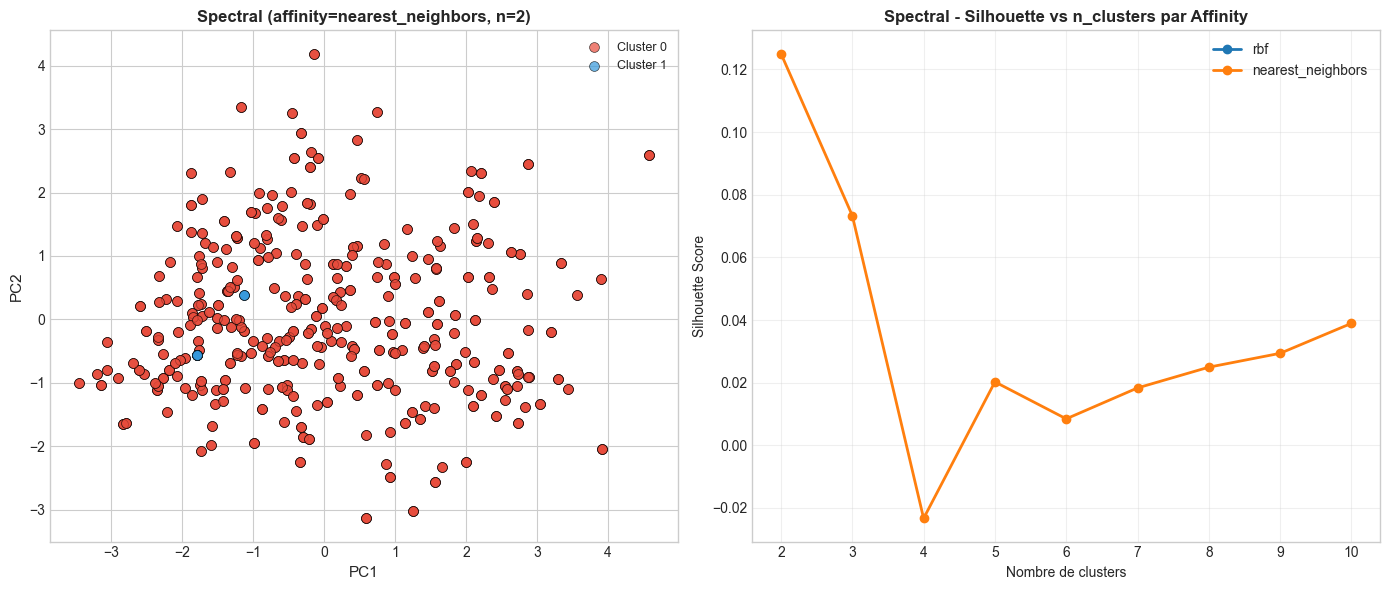

Figure sauvegardée: spectral_analysis.png


In [16]:
# ============================================================================
# VISUALISATION SPECTRAL
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Clusters 2D
ax1 = axes[0]
plot_clusters_2d(X_pca, best_spectral['labels'],
                 f'Spectral ({best_spectral["params"]})', ax=ax1)

# 2. Comparaison des affinités
ax2 = axes[1]
for affinity in affinity_methods:
    silhouettes = [r['silhouette'] for r in spectral_results 
                   if r['affinity'] == affinity and r['silhouette'] is not None]
    n_values = [r['n_clusters'] for r in spectral_results 
                if r['affinity'] == affinity and r['silhouette'] is not None]
    ax2.plot(n_values, silhouettes, 'o-', linewidth=2, markersize=6, label=affinity)
ax2.set_xlabel('Nombre de clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Spectral - Silhouette vs n_clusters par Affinity', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/spectral_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée: spectral_analysis.png")

---

## 9. Comparaison des Algorithmes

In [17]:
# ============================================================================
# TABLEAU COMPARATIF
# ============================================================================

print("\n" + "="*70)
print("COMPARAISON DES ALGORITHMES DE CLUSTERING")
print("="*70)

# Créer DataFrame
comparison_df = pd.DataFrame([{
    'Algorithme': r['algorithm'],
    'Paramètres': r['params'],
    'N Clusters': r['n_clusters'],
    'Silhouette': r['silhouette'],
    'Davies-Bouldin': r['davies_bouldin'],
    'Calinski-Harabasz': r['calinski_harabasz'],
    'N Bruit': r['n_noise'],
    'Temps (s)': r['time']
} for r in all_results if r is not None])

comparison_df = comparison_df.sort_values('Silhouette', ascending=False).reset_index(drop=True)

print("\nTableau comparatif des meilleurs modèles:")
display(comparison_df.style.format({
    'Silhouette': '{:.4f}',
    'Davies-Bouldin': '{:.4f}',
    'Calinski-Harabasz': '{:.2f}',
    'Temps (s)': '{:.4f}'
}).background_gradient(subset=['Silhouette'], cmap='Greens')
 .background_gradient(subset=['Davies-Bouldin'], cmap='Reds_r'))


COMPARAISON DES ALGORITHMES DE CLUSTERING

Tableau comparatif des meilleurs modèles:


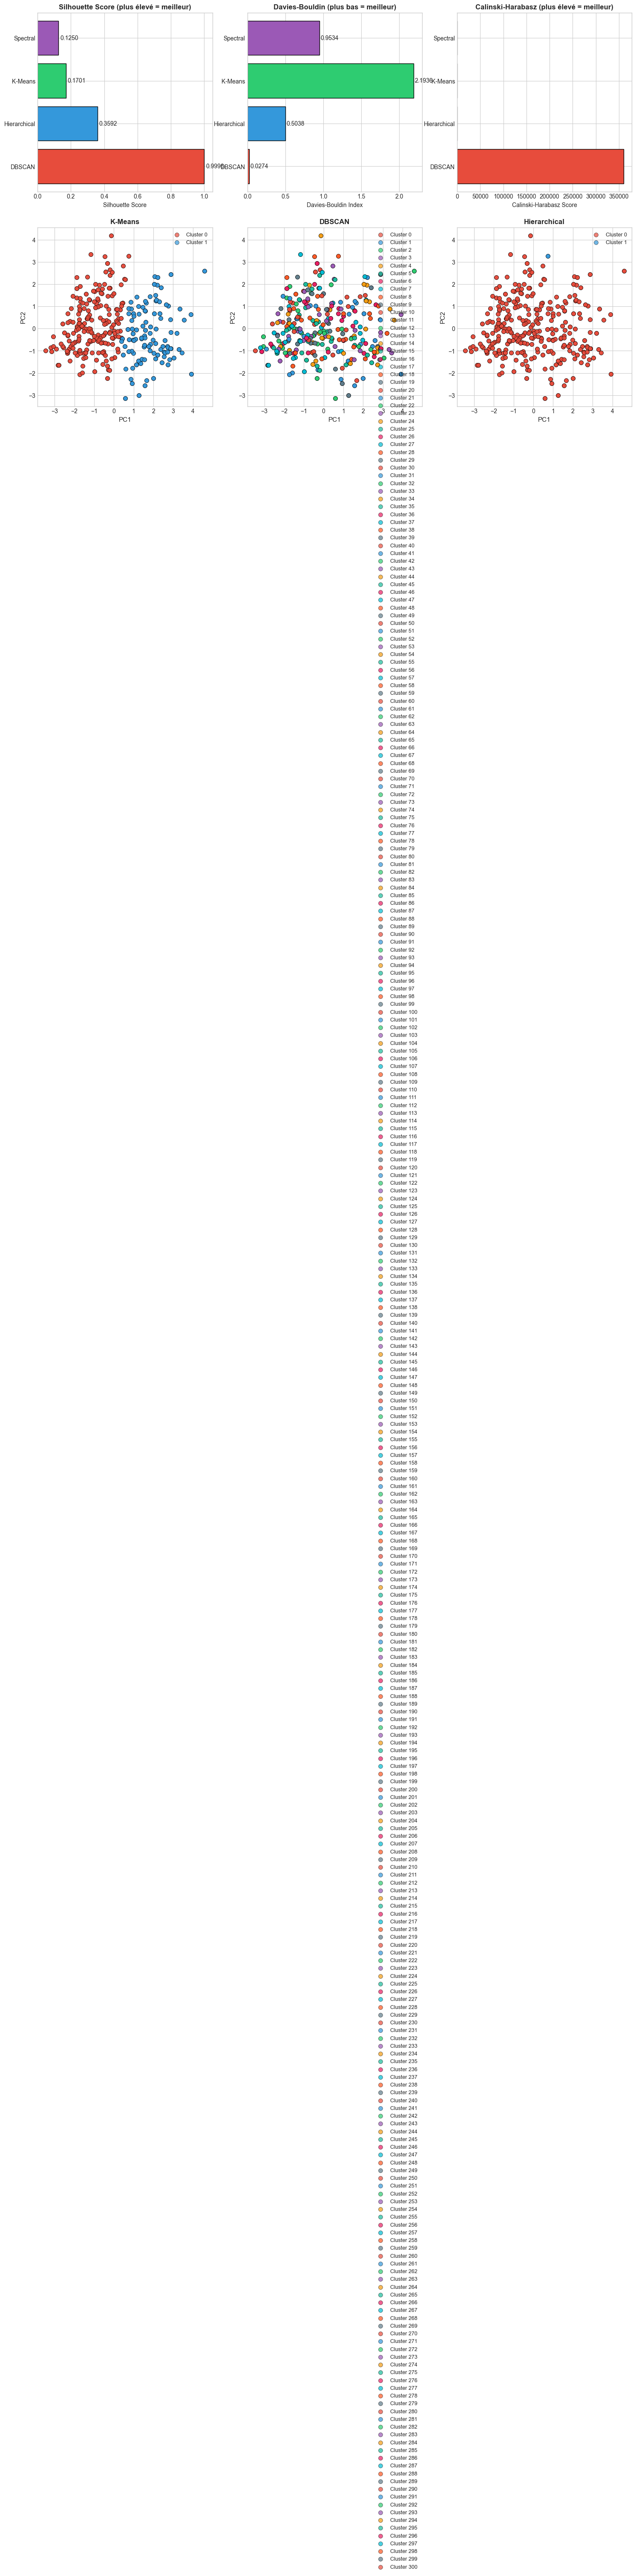

Figure sauvegardée: clustering_comparison.png


In [18]:
# ============================================================================
# VISUALISATION COMPARATIVE
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

algorithms = comparison_df['Algorithme'].tolist()
colors = [CLUSTER_COLORS[i] for i in range(len(algorithms))]

# 1. Silhouette Score
ax1 = axes[0, 0]
bars = ax1.barh(algorithms, comparison_df['Silhouette'], color=colors, edgecolor='black')
ax1.set_xlabel('Silhouette Score')
ax1.set_title('Silhouette Score (plus élevé = meilleur)', fontweight='bold')
for bar, val in zip(bars, comparison_df['Silhouette']):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center')

# 2. Davies-Bouldin
ax2 = axes[0, 1]
bars = ax2.barh(algorithms, comparison_df['Davies-Bouldin'], color=colors, edgecolor='black')
ax2.set_xlabel('Davies-Bouldin Index')
ax2.set_title('Davies-Bouldin (plus bas = meilleur)', fontweight='bold')
for bar, val in zip(bars, comparison_df['Davies-Bouldin']):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center')

# 3. Calinski-Harabasz
ax3 = axes[0, 2]
bars = ax3.barh(algorithms, comparison_df['Calinski-Harabasz'], color=colors, edgecolor='black')
ax3.set_xlabel('Calinski-Harabasz Score')
ax3.set_title('Calinski-Harabasz (plus élevé = meilleur)', fontweight='bold')

# 4-7. Clusters 2D pour chaque algorithme
for idx, (algo_name, result) in enumerate(best_models.items()):
    if result is not None and idx < 3:
        ax = axes[1, idx]
        plot_clusters_2d(X_pca, result['labels'], f'{algo_name}', ax=ax)

plt.tight_layout()
plt.savefig('images/clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure sauvegardée: clustering_comparison.png")

## 10. Analyse des Profils de Clusters

In [19]:
# ============================================================================
# ANALYSE DES PROFILS - MEILLEUR MODÈLE
# ============================================================================

# Utiliser le meilleur modèle global
best_overall = comparison_df.iloc[0]['Algorithme']
best_result = best_models[best_overall]

print(f"\nANALYSE DES PROFILS - {best_overall}")
print("="*70)

# Ajouter les labels au DataFrame
df_analysis = X.copy()
df_analysis['Cluster'] = best_result['labels']
df_analysis['Target_True'] = y_true

# Statistiques par cluster
print("\nCaractéristiques moyennes par cluster:")
cluster_profiles = df_analysis.groupby('Cluster')[feature_names].mean()
display(cluster_profiles.round(2))


ANALYSE DES PROFILS - DBSCAN

Caractéristiques moyennes par cluster:


age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  \
Cluster                                                                  
0        52.0  1.0  0.0     125.0  212.0  0.0      1.0    168.0    0.0   
1        53.0  1.0  0.0     140.0  203.0  1.0      0.0    155.0    1.0   
2        70.0  1.0  0.0     145.0  174.0  0.0      1.0    125.0    1.0   
3        61.0  1.0  0.0     148.0  203.0  0.0      1.0    161.0    0.0   
4        62.0  0.0  0.0     138.0  294.0  1.0      1.0    106.0    0.0   
...       ...  ...  ...       ...    ...  ...      ...      ...    ...   
296      68.0  0.0  2.0     120.0  211.0  0.0      0.0    115.0    0.0   
297      44.0  0.0  2.0     108.0  141.0  0.0      1.0    175.0    0.0   
298      52.0  1.0  0.0     128.0  255.0  0.0      1.0    161.0    1.0   
299      59.0  1.0  3.0     160.0  273.0  0.0      0.0    125.0    0.0   
300      54.0  1.0  0.0     120.0  188.0  0.0      1.0    113.0    0.0   

         oldpeak  slope   ca  thal  
Cluster                             
0            1.0    2.0  2.0   3.0  
1            3.1    0.0  0.0   3.0  
2            2.6    0.0  0.0   3.0  
3            0.0    2.0  1.0   3.0  
4            1.9    1.0  3.0   2.0  
...          ...    ...  ...   ...  
296          1.5    1.0  0.0   2.0  
297          0.6    1.0  0.0   2.0  
298          0.0    2.0  1.0   3.0  
299          0.0    2.0  0.0   2.0  
300          1.4    1.0  1.0   3.0  

[301 rows x 13 columns]

In [20]:
# ============================================================================
# COMPARAISON AVEC LA VRAIE CIBLE
# ============================================================================

print("\nComparaison Clusters vs Diagnostic Réel:")
cross_tab = pd.crosstab(df_analysis['Cluster'], df_analysis['Target_True'], 
                         margins=True, margins_name='Total')
cross_tab.columns = ['Sain (0)', 'Malade (1)', 'Total']
display(cross_tab)

# Taux de maladie par cluster
print("\nTaux de maladie cardiaque par cluster:")
disease_rate = df_analysis.groupby('Cluster')['Target_True'].agg(['sum', 'count', 'mean'])
disease_rate.columns = ['Malades', 'Total', 'Taux (%)']
disease_rate['Taux (%)'] = (disease_rate['Taux (%)'] * 100).round(1)
display(disease_rate)


Comparaison Clusters vs Diagnostic Réel:


Sain (0)  Malade (1)  Total
Cluster                             
0               4           0      4
1               4           0      4
2               4           0      4
3               4           0      4
4               3           0      3
...           ...         ...    ...
297             0           3      3
298             3           0      3
299             3           0      3
300             3           0      3
Total         499         526   1025

[302 rows x 3 columns]


Taux de maladie cardiaque par cluster:


Malades  Total  Taux (%)
Cluster                          
0              0      4       0.0
1              0      4       0.0
2              0      4       0.0
3              0      4       0.0
4              0      3       0.0
...          ...    ...       ...
296            3      3     100.0
297            3      3     100.0
298            0      3       0.0
299            0      3       0.0
300            0      3       0.0

[301 rows x 3 columns]

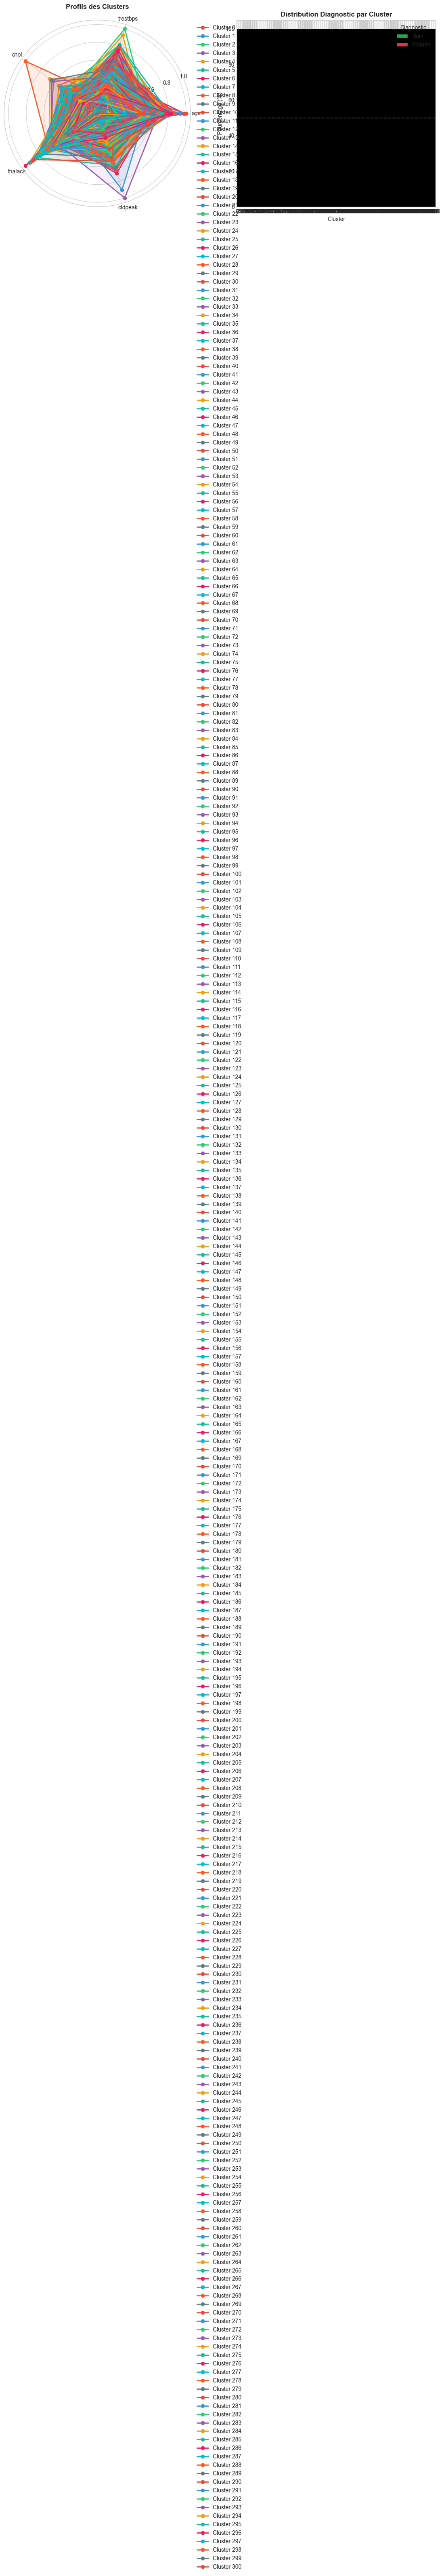

In [21]:
# ============================================================================
# VISUALISATION DES PROFILS
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Radar plot des profils
ax1 = axes[0]

# Normaliser pour le radar
cluster_profiles_norm = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

# Sélectionner quelques variables clés
key_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
angles = np.linspace(0, 2*np.pi, len(key_features), endpoint=False).tolist()
angles += angles[:1]

for cluster in cluster_profiles_norm.index:
    if cluster != -1:  # Exclure le bruit
        values = cluster_profiles_norm.loc[cluster, key_features].tolist()
        values += values[:1]
        color = CLUSTER_COLORS[cluster % len(CLUSTER_COLORS)]
        ax1.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster}', color=color)
        ax1.fill(angles, values, alpha=0.1, color=color)

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(key_features)
ax1.set_title('Profils des Clusters (Radar)', fontweight='bold')
ax1.legend(loc='upper right')

# Convertir en coordonnées polaires
ax1.remove()
ax1 = fig.add_subplot(1, 2, 1, projection='polar')
for cluster in cluster_profiles_norm.index:
    if cluster != -1:
        values = cluster_profiles_norm.loc[cluster, key_features].tolist()
        values += values[:1]
        color = CLUSTER_COLORS[cluster % len(CLUSTER_COLORS)]
        ax1.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster}', color=color)
        ax1.fill(angles, values, alpha=0.1, color=color)
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(key_features)
ax1.set_title('Profils des Clusters', fontweight='bold', pad=20)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# 2. Distribution de la cible par cluster
ax2 = axes[1]
cluster_target = pd.crosstab(df_analysis['Cluster'], df_analysis['Target_True'], normalize='index') * 100
cluster_target.columns = ['Sain', 'Malade']
cluster_target.plot(kind='bar', stacked=True, ax=ax2, 
                    color=['#28A745', '#DC3545'], edgecolor='black')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Pourcentage (%)')
ax2.set_title('Distribution Diagnostic par Cluster', fontweight='bold')
ax2.legend(title='Diagnostic')
ax2.tick_params(axis='x', rotation=0)
ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('images/cluster_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Dashboard Final

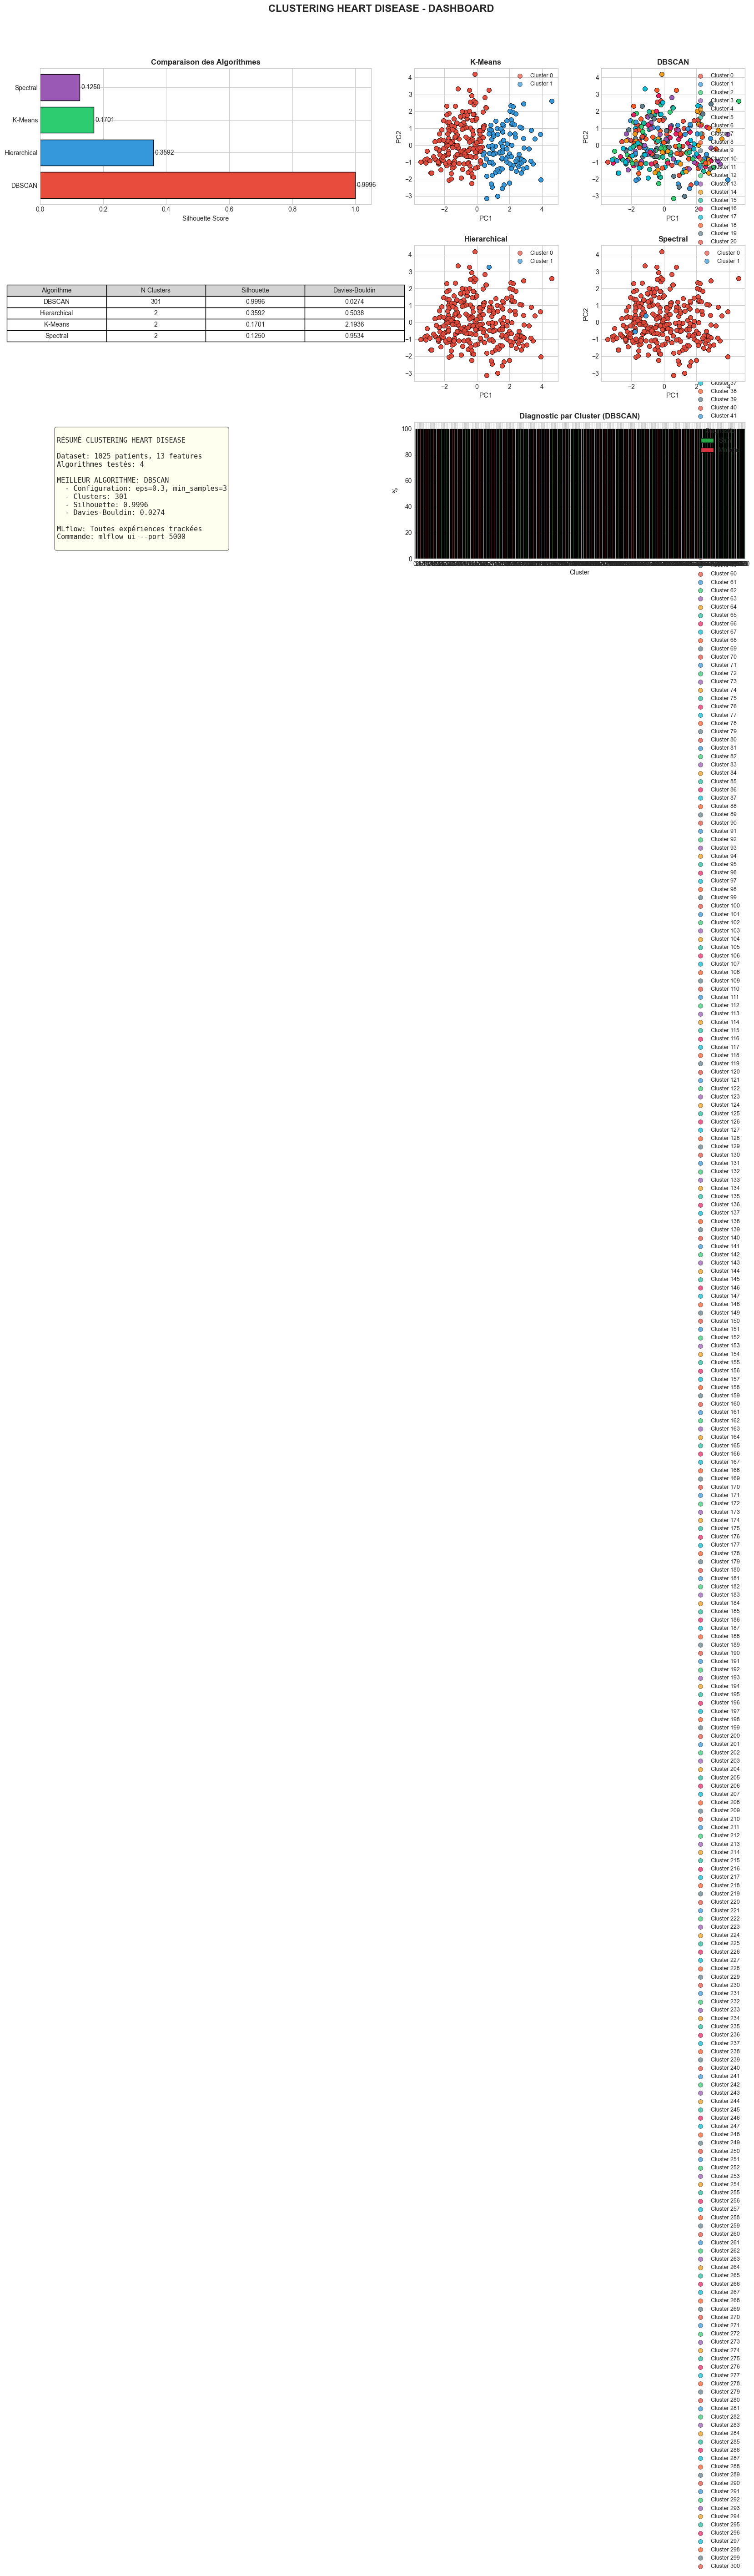

In [22]:
# ============================================================================
# DASHBOARD FINAL
# ============================================================================

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1. Comparaison Silhouette
ax1 = fig.add_subplot(gs[0, 0:2])
colors_bar = [CLUSTER_COLORS[i] for i in range(len(comparison_df))]
bars = ax1.barh(comparison_df['Algorithme'], comparison_df['Silhouette'], 
                color=colors_bar, edgecolor='black')
ax1.set_xlabel('Silhouette Score')
ax1.set_title('Comparaison des Algorithmes', fontweight='bold')
for bar, val in zip(bars, comparison_df['Silhouette']):
    ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center')

# 2-5. Clusters 2D
positions = [(0, 2), (0, 3), (1, 2), (1, 3)]
for idx, (algo_name, result) in enumerate(best_models.items()):
    if result is not None and idx < 4:
        row, col = positions[idx]
        ax = fig.add_subplot(gs[row, col])
        plot_clusters_2d(X_pca, result['labels'], algo_name, ax=ax)

# 6. Métriques tableau
ax6 = fig.add_subplot(gs[1, 0:2])
ax6.axis('off')
table_data = comparison_df[['Algorithme', 'N Clusters', 'Silhouette', 'Davies-Bouldin']].copy()
table_data['Silhouette'] = table_data['Silhouette'].apply(lambda x: f'{x:.4f}')
table_data['Davies-Bouldin'] = table_data['Davies-Bouldin'].apply(lambda x: f'{x:.4f}')
table = ax6.table(cellText=table_data.values, colLabels=table_data.columns,
                  cellLoc='center', loc='center', colColours=['lightgray']*4)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# 7. Résumé
ax7 = fig.add_subplot(gs[2, 0:2])
ax7.axis('off')
best = comparison_df.iloc[0]
summary = f"""
RÉSUMÉ CLUSTERING HEART DISEASE

Dataset: {len(X)} patients, {len(feature_names)} features
Algorithmes testés: 4

MEILLEUR ALGORITHME: {best['Algorithme']}
  - Configuration: {best['Paramètres']}
  - Clusters: {best['N Clusters']}
  - Silhouette: {best['Silhouette']:.4f}
  - Davies-Bouldin: {best['Davies-Bouldin']:.4f}

MLflow: Toutes expériences trackées
Commande: mlflow ui --port 5000
"""
ax7.text(0.05, 0.95, summary, transform=ax7.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

# 8. Distribution cible par cluster (meilleur modèle)
ax8 = fig.add_subplot(gs[2, 2:])
cluster_target = pd.crosstab(df_analysis['Cluster'], df_analysis['Target_True'], normalize='index') * 100
cluster_target.columns = ['Sain', 'Malade']
cluster_target.plot(kind='bar', stacked=True, ax=ax8,
                    color=['#28A745', '#DC3545'], edgecolor='black')
ax8.set_xlabel('Cluster')
ax8.set_ylabel('%')
ax8.set_title(f'Diagnostic par Cluster ({best["Algorithme"]})', fontweight='bold')
ax8.tick_params(axis='x', rotation=0)
ax8.legend(title='Diagnostic', loc='upper right')

plt.suptitle('CLUSTERING HEART DISEASE - DASHBOARD', fontsize=16, fontweight='bold', y=0.98)
plt.savefig('images/clustering_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Sauvegarde des Résultats

In [24]:
# ============================================================================
# SAUVEGARDE
# ============================================================================

# Sauvegarder le tableau comparatif
comparison_df.to_csv('clustering_results.csv', index=False)
print("\u2705 Résultats sauvegardés: clustering_results.csv")

# Sauvegarder les profils de clusters
cluster_profiles.to_csv('cluster_profiles.csv')
print("\u2705 Profils sauvegardés: cluster_profiles.csv")

# Sauvegarder les labels du meilleur modèle
labels_df = pd.DataFrame({
    'Index': range(len(X)),
    'Cluster': best_result['labels'],
    'Target_True': y_true.values
})
labels_df.to_csv('best_clustering_labels.csv', index=False)
print("\u2705 Labels sauvegardés: best_clustering_labels.csv")

print("\n" + "="*70)
print("CLUSTERING TERMINÉ AVEC SUCCÈS !")
print("="*70)
print(f"\nFichiers générés:")
print("  - kmeans_analysis.png")
print("  - dbscan_analysis.png")
print("  - hierarchical_analysis.png")
print("  - spectral_analysis.png")
print("  - clustering_comparison.png")
print("  - cluster_profiles.png")
print("  - clustering_dashboard.png")
print("  - clustering_results.csv")
print("  - cluster_profiles.csv")
print("  - best_clustering_labels.csv")

✅ Résultats sauvegardés: clustering_results.csv
✅ Profils sauvegardés: cluster_profiles.csv
✅ Labels sauvegardés: best_clustering_labels.csv

CLUSTERING TERMINÉ AVEC SUCCÈS !

Fichiers générés:
  - kmeans_analysis.png
  - dbscan_analysis.png
  - hierarchical_analysis.png
  - spectral_analysis.png
  - clustering_comparison.png
  - cluster_profiles.png
  - clustering_dashboard.png
  - clustering_results.csv
  - cluster_profiles.csv
  - best_clustering_labels.csv
